In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 1000)

In [18]:
filename = 'list_of_dicts.pkl'
with open(filename, 'rb') as file:
    list_of_dicts = pickle.load(file) 

In [3]:

all_relationship_terms = [
    'Spouses',
    'Spouse',
    'Spouse(s)',
    'Partners',
    'Partner',
    'Partner(s)',
]

spouse_terms = [
    'Spouses',
    'Spouse',
    'Spouse(s)',
]

children_terms = [
    'Children',
    'Parent',
    'Parents',
    'Mother',
    'Father',
    'Parent(s)',
    'Children',
]

In [56]:
tmp_df = pd.DataFrame(list_of_dicts)
for entry in list_of_dicts:
    if entry['actor'] == 'Kevin Hart':
        print(entry)

{'actor': 'Kevin Hart', 'url': 'https://en.wikipedia.org/wiki/Kevin_Hart'}


# Create DataFrame

In [61]:
filtered_data = [
    {
        k: v.replace('\u200b', '') if k in all_relationship_terms else v
        for k, v in entry.items() if k in ['actor'] + all_relationship_terms
    }
    for entry in list_of_dicts
] # add this to replace \xa0

# Define the regex pattern to match each marriage/partnership
pattern = re.compile(r'([a-zA-Z\s]+\(.*?\))')
# pattern = re.compile(r'([a-zA-Z\s]+(?:\(.*?\))?)')

# Initialize an empty list to store the rows
rows = []

# Iterate through each entry in the filtered_data
for entry in filtered_data:
    actor = entry['actor']
    for key in all_relationship_terms:
        if key in entry:
            # Find all matches for the current relationship term (Spouses, Partners, etc.)
            matches = pattern.findall(entry[key])
            for match in matches:
                rows.append({
                    'actor': actor,
                    'variable': key,
                    'value': match.strip()  # Strip any leading/trailing whitespace
                })
    # if not any(x in all_relationship_terms for x in entry.keys()):
    #     rows.append({
    #             'actor': actor,
    #             'variable': 'Never',
    #             'value': 'never'  # Strip any leading/trailing whitespace
    #         })



In [72]:
# Create the DataFrame from the rows
df = pd.DataFrame(rows, columns=['actor', 'variable', 'value'])

## extract names & the details
df[['name', 'details']] = df['value'].str.extract(r'([a-zA-Z\s]+)\s*(\(.*?\))').apply(lambda x: x.str.strip())
pattern = re.compile(r'([a-zA-Z]+\.? \d{4})\s* *;? *\s*([a-zA-Z]+\.? \d{4})?') #re.compile(r'([a-zA-Z]{1,4}\.\s*\d{4})(?:;\s*([a-zA-Z]{1,4}\.\s*\d{4}))?')
pattern = re.compile(r'\(\s*([a-zA-Z]{1,5}\.?\s*\d{4})\s*(?:;?\s*([a-zA-Z]{1,5}\.?\s*\d{4}))?\s*\)')
## Apply the regex to extract the matches into two columns
df[['first_event', 'second_event']] = df['details'].str.extract(pattern)

## get out the m. and the year
df['first_abbrev'] = df['first_event'].str.extract(r'(\w+)\.? ')
df['second_abbrev'] = df['second_event'].str.extract(r'(\w+)\.? ')
## if your marriage makes it, then give the np.nan a "surv" for survived
df.loc[ (df.variable.isin(spouse_terms)) & ( df['second_abbrev'].isnull() ), 'second_abbrev'] = 'surv'


# QA + Sanity Checking

In [73]:
##
# come back and address
df[(df['variable'].isin(spouse_terms)) & (df['first_event'].isnull())][['actor', 'variable', 'value', 'first_event']]#['value'].iloc[0]
# df[df['actor'] == 'Elizabeth Taylor']
# df[(df['variable'].isin(spouse_terms)) & (df['second_event'].isnull())][['value', 'second_event']]
# df[(df['variable'].isin(spouse_terms)) & (df['second_event'].isnull())]['value'].unique()

## see how many lost
# len(tmp_df) - df.actor.nunique()
# tmp_df[~tmp_df['actor'].isin(df.actor.unique())][['actor'] + all_relationship_terms]

## check how many don't have semi-colons in them
# len(df[df['variable'].isin(spouse_terms)])
# df[df['variable'].isin(spouse_terms)].isnull().sum()

## can add a check to see how many have two sets of numbers indicating two events
# df[(df['variable'].isin(spouse_terms)) & (df['first_event'].notnull())]['first_event'].unique()

## looking at abbrevs
# df['first_abbrev'].unique()
# len(df[ ( df['variable'].isin(spouse_terms) ) & ~( df['first_abbrev'].isin(['m']) ) ]) # not too bad

# df['second_abbrev'].unique()
# df[ ( df['variable'].isin(spouse_terms) ) & ( df['second_abbrev'].isnull())  ].details.unique()

,actor,variable,value,first_event
33,Elizabeth Taylor,Spouses,( m. 1950 ; div. 1951 ),NaN
38,Elizabeth Taylor,Spouses,( m. 1975 ; div. 1976 ),NaN
55,Kate Winslet,Spouses,( m. 2012),NaN
58,Sophia Loren,Spouses,( m. 1957; ann. 1962),NaN
59,Sophia Loren,Spouses,( m. 1966; died 2007),NaN
134,Natalie Wood,Spouses,( m. 1972 ),NaN
140,Joan Crawford,Spouses,( m. 1929; div. 1933),NaN
164,Joan Fontaine,Spouses,( m. 1964; div. 1969),NaN
170,Regina King,Spouse,( m. 1997; div. 2007),NaN
237,Robert Redford,Spouses,"Lola Van Wagenen ( m. 1958, divorced)",NaN


# Analysis

In [35]:
working = df[df['variable'].isin(spouse_terms)]

## make bind annulments, separations, and divorces together. died and survived are the same
working = working.replace('ann', 'ended').replace('annul', 'ended').replace('div', 'ended').replace('sep', 'ended')\
                 .replace('died', 'survived').replace('surv', 'survived').replace('m', 'married')

## drop the broken ones
working = working[~working['first_abbrev'].isin(['ended','c'])]


##### Counts of marriages, actors
## Number of actors who were married
working.actor.nunique()

## Number of marriages. 
len(working)

## count of marriages per actor
actor_marriage_count_table = working.groupby('actor')['first_abbrev'].count().reset_index().rename(columns = {'first_abbrev':'count'})

## Num of actors who were married 1,2,3, etc. times
marriage_distro_table = actor_marriage_count_table.groupby('count')['actor'].count().reset_index()
cutoff_number = 3
## create 3+ group
marriage_distro_table['group'] = marriage_distro_table['count'].apply(lambda x: f'{cutoff_number}+' if x >= cutoff_number else str(x))
# Group by the new 'group' column and sum the 'actor' counts
marriage_distro_trunc = marriage_distro_table.groupby('group', as_index=False)['actor'].sum()
marriage_distro_trunc

,group,actor
0,0,9
1,1,423
2,2,214
3,3+,158


In [36]:
# Barchart function
def basic_barchart(x, y, df, xlabel, ylabel, title, hue = None):
    if hue:
        ax = sns.barplot(x=x, y=y, data=df, hue=hue, edgecolor='black')
    else:
        ax = sns.barplot(x=x, y=y, data=df, edgecolor='black')

    # for index, row in df.iterrows():
    #     # addition = row['count'] * 0.02
    #     ax.text(row[x], index + 10, row['actor'], color='black', ha="center", va="bottom")
    # Add text labels
    for container in ax.containers:
        # Determine whether the data is in percentage format (decimals) or whole numbers
        labels = []
        for v in container.datavalues:
            if isinstance(v, float) and v < 1:
                labels.append(f'{v:.0%}')  # Convert to percentage format
            else:
                labels.append(f'{int(v)}')  # Keep as a whole number

        ax.bar_label(container, labels=labels, label_type='edge', padding=3)


    # Adding labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Show the plot
    plt.show()

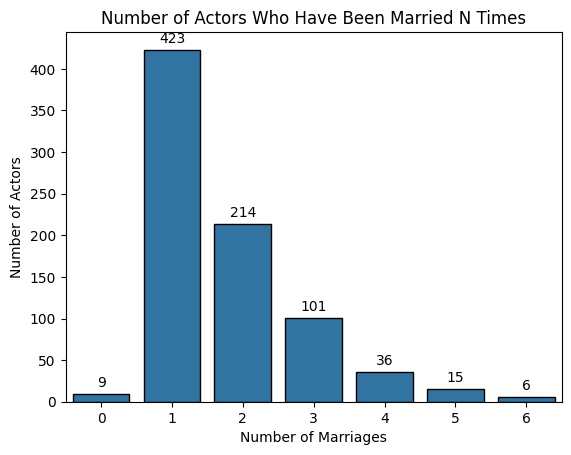

In [37]:
x = 'count'
y = 'actor'
df = marriage_distro_table
xlabel = 'Number of Marriages'
ylabel = 'Number of Actors'
title = 'Number of Actors Who Have Been Married N Times'
basic_barchart(x, y, df, xlabel, ylabel, title)

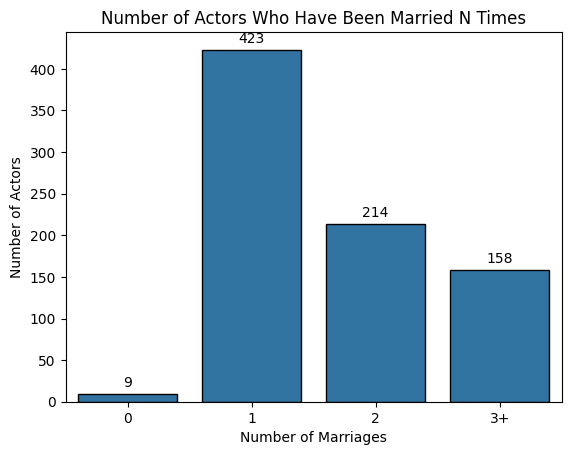

In [38]:
x = 'group'
y = 'actor'
df = marriage_distro_trunc
xlabel = 'Number of Marriages'
ylabel = 'Number of Actors'
title = 'Number of Actors Who Have Been Married N Times'
basic_barchart(x, y, df, xlabel, ylabel, title)

<Figure size 640x480 with 0 Axes>

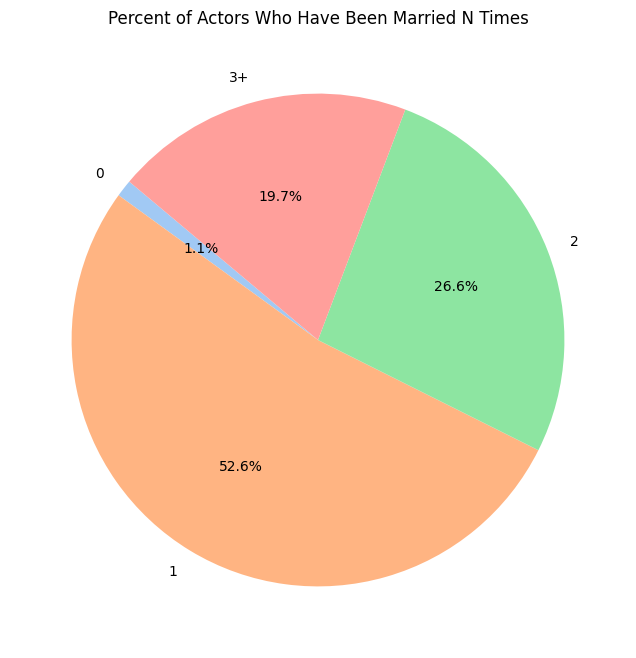

In [39]:
plt.clf()
plt.figure(figsize=(8, 8))
plt.pie(marriage_distro_trunc['actor'], labels=marriage_distro_trunc['group'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))

# Add a title
plt.title('Percent of Actors Who Have Been Married N Times')

# Display the pie chart
plt.show()

In [40]:
##### Rates of Divorces

assert working['actor'].isnull().sum() == 0

## divorce rate across all
divorce_counts = working.groupby(['first_abbrev', 'second_abbrev'])['actor'].count()
divorce_counts / divorce_counts.sum()# lost 40ish marriages, can look into those


## divorce rates for 1st, 2nd, 3rd etc. marriages

"""
what we can do is based on what number marriage it is, label it in the main table. We could do this with a window function, if you show up 3 times in the main table you had 3 marriages, 2 of which died.
Then groupby the 1st, 2nd, 3rd and the surv/ended counts
""" 
working['marriage_number'] = working.groupby(['actor']).cumcount() + 1
working.loc[working['marriage_number'] >= cutoff_number, 'marriage_number_trunc'] = f'{cutoff_number}+'
working.loc[working['marriage_number'] < cutoff_number, 'marriage_number_trunc'] = working.loc[working['marriage_number'] < cutoff_number, 'marriage_number']
# working['marriage_number'] = 'marriage no. ' + working['marriage_number'].apply(str)

working.groupby(['marriage_number', 'second_abbrev'])['actor'].count() / working.groupby('marriage_number')['actor'].count()#.sum()
working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count() / working.groupby('marriage_number_trunc')['actor'].count()#.sum()


marriage_number_trunc  second_abbrev
1                      ended            0.590796
                       survived         0.409204
2                      ended            0.548556
                       survived         0.451444
3+                     ended            0.520755
                       survived         0.479245
Name: actor, dtype: float64

In [41]:
# divorce_counts.reset_index()
working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count().reset_index()
# working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count()

,marriage_number_trunc,second_abbrev,actor
0,1,ended,475
1,1,survived,329
2,2,ended,209
3,2,survived,172
4,3+,ended,138
5,3+,survived,127


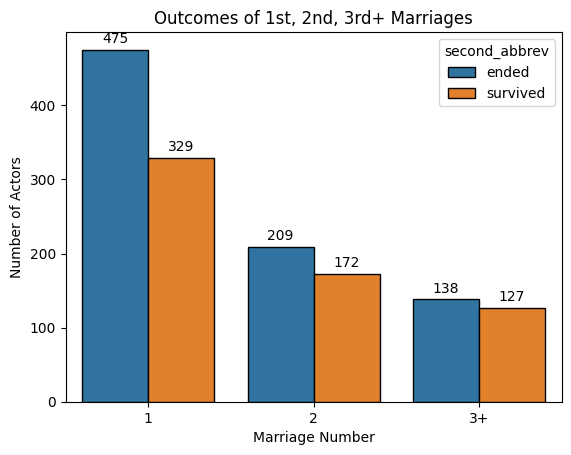

In [42]:
x = 'marriage_number_trunc'
y = 'actor'
hue = 'second_abbrev'
df = working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count().reset_index()
xlabel = 'Marriage Number'
ylabel = 'Number of Actors'
title = 'Outcomes of 1st, 2nd, 3rd+ Marriages'
basic_barchart(x, y, df, xlabel, ylabel, title, hue)

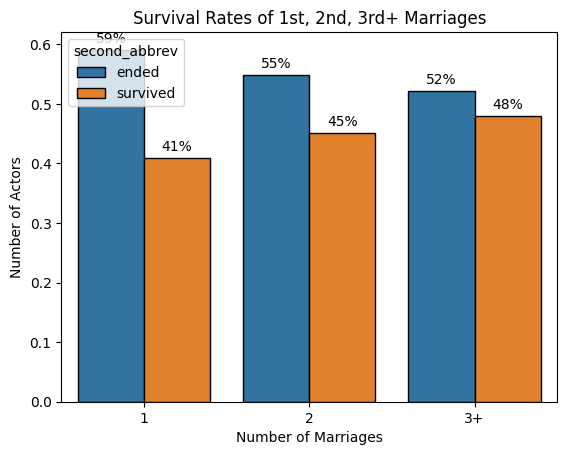

In [43]:
working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count().reset_index()
# working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count()

x = 'marriage_number_trunc'
y = 'actor'
hue = 'second_abbrev'
df = (working.groupby(['marriage_number_trunc', 'second_abbrev'])['actor'].count() / working.groupby(['marriage_number_trunc'])['actor'].count()).reset_index()
xlabel = 'Number of Marriages'
ylabel = 'Number of Actors'
title = 'Survival Rates of 1st, 2nd, 3rd+ Marriages'
basic_barchart(x, y, df, xlabel, ylabel, title, hue)

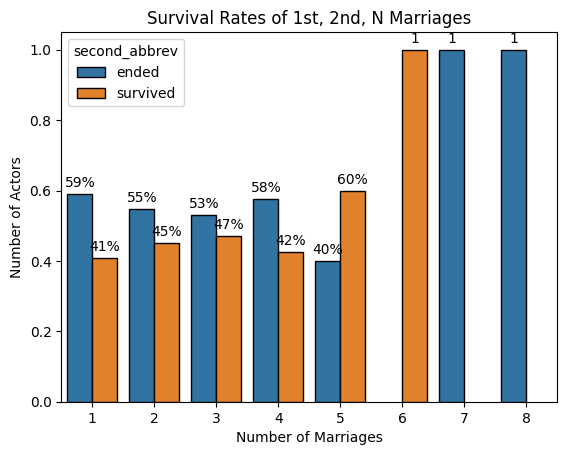

In [44]:
x = 'marriage_number'
y = 'actor'
hue = 'second_abbrev'
df = (working.groupby(['marriage_number', 'second_abbrev'])['actor'].count() / working.groupby(['marriage_number'])['actor'].count()).reset_index()
xlabel = 'Number of Marriages'
ylabel = 'Number of Actors'
title = 'Survival Rates of 1st, 2nd, N Marriages'
basic_barchart(x, y, df, xlabel, ylabel, title, hue)

# Additional QA

In [ ]:
working[ ( working['second_event'].isnull() ) & ( working['second_abbrev'].isnull() ) ] # this check, need to make sure that there's no second events we're missing
working[working['first_abbrev'] == 'c']
working[working['first_abbrev'] == 'ended']
df[df['actor'] == 'Jean Dujardin']
actor_marriage_count_table[actor_marriage_count_table['count'] == 0]

In [ ]:
working[working['actor'] == 'Christoph Waltz']